## Stochastic Analysis and Monte Carlo Simulations

Stochastic analysis is a central tool in modern data science especially when focused on financial engineering. Monte Carlo simulations serve as the central tool when generating samples of random variables and stochastic processes. In this brief tutorial we study three general classes of stochastic processes via Monte Carlo simulations. These techniques serve as the foundation for various applications financial engineering in particular, and data science in general. 

Monte Carlo simulations is the most flexible numerical method when it comes to evaluating mathematical objects such as integrals, and specifically when computing stochastic differential equations. The flexibility, however, comes with the cost of a relatively high computational burden due to the fact that simulating hundreds of millions of complex computations is not out of the ordinary.
 the ordinary. 

### Simulating Random Variables

Consider the Black-Scholes-Merton model for option pricing. In this setup, the stochastic process follows a Geometric Brownian Motion:

$ dS_t  = \mu S_t \ dt + \sigma S_t \ dW_t$.

We have the following closed form solution for simulation purposes for solution the Geometric Brownian Motion:

$ S_T = S_0 \ \mathbf{exp}\Big[ \big(\mu - \frac{\sigma^2}{2} \big)T + \sigma \sqrt{T} z \Big],$

where, according to the economic interpretation from the perspective of simulations futures indices, $\mu$ is the constant riskless short rate, $\sigma$ is the standard deviation of the process $S_t$ (constant volatility), and $z$ is a standard-normally distributed random variable. The model is parameterized and simulated as follows:

In [59]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

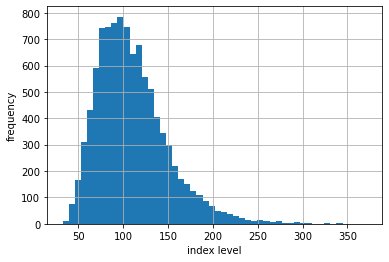

In [60]:
S0 = 100 # initial value
mu = 0.05 # constant short rate
sigma = 0.25 # constant volatility
T = 2.0 # in years
I = 10_000 # number of random draws
gm_bm = S0 * np.exp((mu - (sigma**2)/2)*T + sigma*np.sqrt(T)*npr.standard_normal(I))

plt.hist(gm_bm, bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

As we see, the distribution appears to be a log-normal distribution as the name of the stochastic process suggests. We can verify this via a more rigorous approach by comparing the properties of the distribution with an actual log-normal distribution.

In [46]:
log_normal = S0 * npr.lognormal((mu - (sigma**2)/2)*T, sigma*np.sqrt(T), size=I)

def stat_quants(d_1, d_2):
    ''' Compare the statistical properties of two distributions. 
    
    Parameters
    ==========
    d_1 : np.array
        a sample from the first distribution
    d_2 : np.array
        a sample from the second distribution
        
    Returns
    =======
    comp : pd.DataFrame
        a dataframe contrasting the the properties of the two distributions 
    '''
    dist_1 = pd.Series(scs.describe(d_1),
                  index=['size', 'min/max', 'mean', 'variance', 'skewness', 'kurtosis'],
                  name='Dist. 1')
    dist_2 = pd.Series(scs.describe(d_2),
                  index=['size', 'min/max', 'mean', 'variance', 'skewness', 'kurtosis'],
                  name='Dist. 2')
    
    comp = pd.concat([dist_1, dist_2], axis=1)

    return comp

stat_quants(log_normal, gm_bm)

,Dist. 1,Dist. 2
size,10000,10000
min/max,"(25.204904495021946, 351.18213579439936)","(27.688393923004146, 516.1313402098466)"
mean,110.481,110.304
variance,1626.5,1651.35
skewness,1.13049,1.25387
kurtosis,2.22274,3.365


As we see, both simulations look very similar, and we can conclude that it is not an un-reasonable assumption that the stochastic process results into a log-normal distribution. 

### Stochastic Processes

Stochastic processes are usually modelled as a sequence of random variables. How the Monte Carlo sampling is done is a central topic of discussion in the literature, as well as in building applications. Here we concentrate on i.i.d. (independent and identically distributed) sampling. General applications however focus on something called the Markov property, which heuristically states that tomorrow's value is only dependent on today's state of the process.

#### Geometric Brownian Motion

Again, consider the stochastic differential equation (SDE):

$dS_t = \mu S_t \ dt + \sigma S_t \ dW_t$.

Here $W_t$ is the Wiener-process, i.e. a mathematical formulation of the Brownian motion. The SDE is called a geometric Brownian motion. The values of $S_t$ are log-normally distributed and the marginal returns $\frac{dS_t}{S_t}$ are normally distributed. 

The SDE can be made discrete via the Euler scheme with $\Delta t$ representing a discrete interval of the time-step $t$. This yields to

$S_t = S_{t - \Delta t} \  \mathbf{exp} \Big[\big(\mu - \frac{\sigma^2}{2}\big) \Delta t \ + \ \sigma \sqrt{\Delta t} z_t \Big]$.

The MC simulation of this process is straightforward.

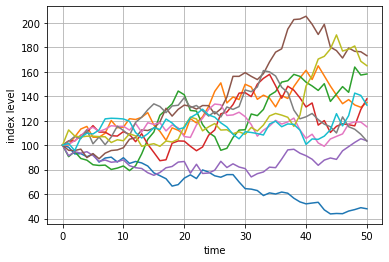

In [63]:
I = 10000
steps = 50
dt = T / steps
S = np.zeros((steps+1, I))
S[0] = S0
for t in range(1, steps+1):
    S[t] = S[t - 1] * np.exp((mu - (sigma**2)/2)*dt + sigma*np.sqrt(dt)*npr.standard_normal(I))

plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

#### Square-root Diffusion Process 

Mean-reverting processes play a significant role in electrical and financial engineering applications. In economic applications these are used to model short rates and in general applications the volatility of a stochastic processes, for example. A popular and widely used model is the square-root diffusion. To provide some perspective consider the following SDE:

$dx_t = \kappa(\theta -x_t) \ dt \ + \ \sigma \sqrt{x_t} \ dW_t$, where

$x_t$ is the state of the process at time $t$, $\kappa$ is the mean-reversion factor, $\theta$ is the long-term mean of the process, $\sigma$ is the volatility, and $W_t$ is the Wiener-process.

It is well known that the values of $x_t$ are chi-squared distributed. While the Euler scheme is robust for the geometric Brownian motion, it ends up being biased for the majority of alternative stochastic process. Nevertheless, the use of an Euler scheme is in many cases desirable due to numerical and computational reasons.

We proceed to present the biased discretization for the square-root diffusion. Let $s := t - \Delta t$ and $x^+ := \mathbf{max}[x, 0]$, we have:

$\hat{x}_t = \hat{x}_s + \kappa ( \theta - \hat{x}_s^+)\Delta t + \sigma \sqrt{\hat{x}_s^+} \sqrt{\Delta t}z_t$,

$x_t = \hat{x}_t^+$.

The square-root diffusion has the important characteristic of remaining strictly positive over the evolution of the process. The Euler scheme does not exclude negative values which is why we only work with the positive version of the process above. For this reason, the simulations become slightly more complicated, as we need two `ndarray` objects:

In [64]:
x0 = 0.05
kappa = 3.0
theta = 0.02
sigma = 0.1

I = 10000
M = 50
dt = T / M
def srd_euler():
    xh = np.zeros((M + 1, I))
    x1 = np.zeros_like(xh)
    xh[0] = x0
    x1[0] = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1]
        + kappa * (theta - np.maximum(xh[t - 1], 0)) * dt
        + sigma * np.sqrt(np.maximum(xh[t - 1], 0)) * np.sqrt(dt)
        * npr.standard_normal(I))
    x1 = np.maximum(xh, 0)
    return x1
x1 = srd_euler()

We continue to show the distribution of process as simulated above by MC simulation.

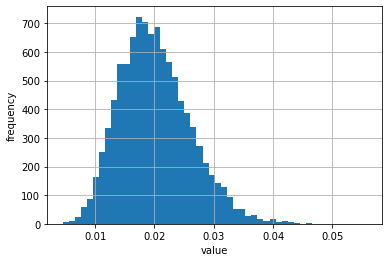

In [65]:
plt.hist(x1[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

As we study the paths of the stochastic process, we observe the negative down-wards average drift and the convergence to $\theta=0.02$ 

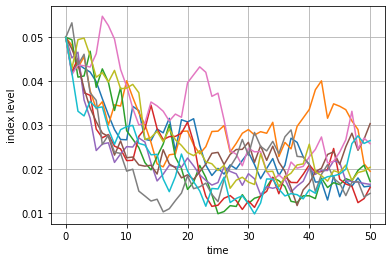

In [66]:
plt.plot(x1[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)


Let us now be more exact and present a robust form of the discretization scheme for the stochastic process. This is based on a chi-squared distribution with $df = \frac{4\theta \kappa}{\sigma^2}$ degrees of freedom and the non-centrality parameter $nc = \frac{4\kappa e^{-\kappa \Delta t}}{\sigma^2 (1-e^{-\kappa \Delta t})} x_s.$ We thus have 

$x_t = \frac{4\kappa e^{-\kappa \Delta t}}{4\kappa} \chi^2_d \Big(\frac{4\kappa e^{-\kappa \Delta t}}{\sigma^2 (1-e^{-\kappa \Delta t})} x_s \Big)$

We proceed to construct the MC simulation, the distribution of the process, and a sample of paths.  

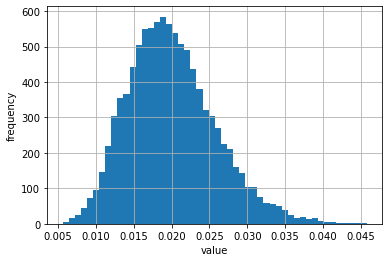

In [68]:
def srd_exact():
    x2 = np.zeros((M + 1, I))
    x2[0] = x0
    for t in range(1, M + 1):
        df = 4 * theta * kappa / sigma ** 2
        c = (sigma ** 2 * (1 - np.exp(-kappa * dt))) / (4 * kappa)
        nc = np.exp(-kappa * dt) / c * x2[t - 1]
        x2[t] = c * npr.noncentral_chisquare(df, nc, size=I)
    return x2
x2 = srd_exact()

plt.hist(x2[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)



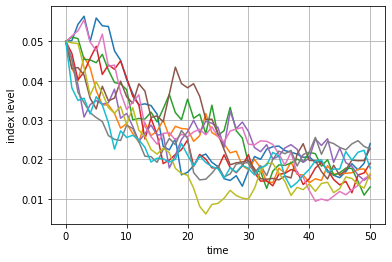

In [69]:
plt.plot(x2[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

The paths display the negative drift and convergence to $\theta$ as to be expected. It would be interesting to know what the statistical difference between the biased and robust versions of the square-root diffusion processes is. We inspect this via presenting the statistical quantities of the distributions as we did with the geometric Brownian motion and log-normal distributions. 

In [70]:
stat_quants(x1[-1], x2[-1])

,Dist. 1,Dist. 2
size,10000,10000
min/max,"(0.004508058929184789, 0.055811376634228804)","(0.005592609167290889, 0.045793722200427926)"
mean,0.0201061,0.0200284
variance,3.58638e-05,3.36143e-05
skewness,0.563247,0.571178
kurtosis,0.499077,0.426779


The comparison shows that the biased version of the process compares fairly well, however we see some discrepancy with the skewness and kurtosis. However, the main difference is the computational complexity when it comes to sampling from the robust process. Thus, we would recommend always reverting to the bias yet computationally less complex process. 

We leave our analysis of the square-root diffusion process here and move on to study stochastic volatility models.

#### Stochastic Volatility

One of the main drawbacks of popular stochastic applications is the constant volatility of the model. However, in real-world we observe that the volatility of stochastic processes are themselves stochastic processes, especially in financial markets. Thus, a major advancement was the introduction of stochastic volatility models. We present one of the most popular ones by Heston below:

$dS_t = \mu S_t \ dt + \sqrt{\nu}S_t \ dW_t^1$,

$d\nu_t = \kappa (\theta_\nu - \nu_t) \ dt + \sigma_\nu \sqrt{\nu_t} \ dW_t^2$,

$dW_t^1dW_t^2 = \rho$.

The parameters are easy to understand when we think of them in the light of our discussions about geometric Brownian motion and square-root diffusion process above. The parameter $\rho$ represents the correlation between the stochastic processes that drive the system. 

Since we are introducing correlation into the system, we need to add a level of complexity into the MC simulations. Thus, to account for the correlation, we determine the Cholesky decomposition of the correlation matrix given the parameters for the system. Cholesky decomposition is a decomposition of a positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose. This is particularly applied in numerical simulations such as MC simulations. 

In [71]:
S0 = 100.
r = 0.05
v0 = 0.1
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6
T = 1.0

corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

cho_mat

array([[1. , 0. ],
       [0.6, 0.8]])

For the volatility process we apply the square-root diffusion process via the Euler scheme applying the correlation structure. The first step is to generate the whole set random draws for both processes. 

In [72]:
M = 50
I = 10000
ran_num = npr.standard_normal((2, M + 1, I))

dt = T / M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt
    + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt)
    * ran[1])
v = np.maximum(vh, 0)

For the main process we apply the Euler scheme for the geometric Brownian motion with the correlation structure:

In [73]:
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt +
                    np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

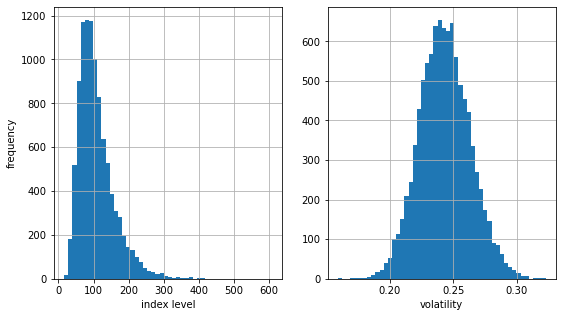

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.grid(True)
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility')
ax2.grid(True)

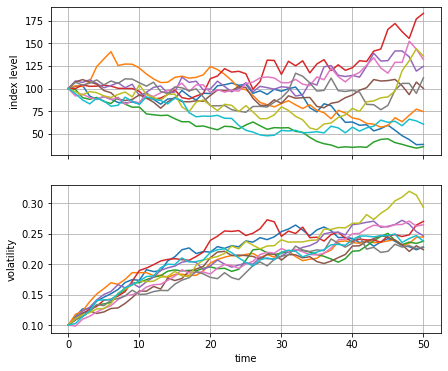

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6))
ax1.plot(S[:, :10], lw=1.5)
ax1.set_ylabel('index level')
ax1.grid(True)
ax2.plot(v[:, :10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility')
ax2.grid(True)

Another advantage of working with the Euler scheme is that correlation is easily and consistently accounted for since we only need to sample from a standard normal distribution. Should we use Euler for one process and chi squared-based for the volatility, this would not be as straight forward. 

We see that the volatility process has a positive drift on average as would be expected with $\theta = 0.25$. 

Finally let's compare the statistics of the two distributions as we have done above. 

In [76]:
stat_quants(S[-1], v[-1])

,Dist. 1,Dist. 2
size,10000,10000
min/max,"(15.950274320793621, 606.7805502058926)","(0.1589177255205149, 0.3228342025616061)"
mean,108.335,0.243217
variance,2698.88,0.000403105
skewness,1.68291,0.127511
kurtosis,5.75175,0.0225597


#### Poisson Jump Diffusion Process

Jump diffusion processes have become popular in financial engineering applications due to fat tails in financial data. We proceed to add an extra layer of stochastic dynamics to drive the geometric Brownian motion. That is, we have

$dS_t = (\mu - \mu_j) S_t \ d_t + \sigma S_t \ dW_t + J_t S_t \ dP_t$ where

$S_t$ is the state of the stochastic process, $\mu$ is the drift, $\mu_j := \lambda \big(e^{\beta_j + \frac{\delta^2}{2}} -1 \big)$ is the drift correction for jump to maintain risk neutrality, $\sigma$ is the standard deviation of the process, $W_t$ is the Wiener process, $J_t$ is the jump at date $t$ where 

$log(1+J_t) \approx \mathbf{N}\big( log(1+\mu_j) - \frac{\delta^2}{2}, \delta^2 \big)$, where

$\mathbf{N}$ is a Gaussian standard normal cumulative distribution function, and $P_t$ is a Poisson process with intensity $\lambda$.

In order to proceed with numerical simulations, we need to provide the Euler discretization for the process. Let $z_t^n$ be a standard normal Gaussian and $y_t$ be Poisson with intensity $\lambda$. Then we have the Euler scheme such that

$S_t = S_{t-\Delta t} \Big( e^{\big( \mu - \mu_j - \frac{\sigma^2}{2} \big) \Delta t + \sigma \sqrt{\Delta t}z_t^1} + \big( e^{\mu_j + \delta z_t^2} -1 \big)y_t \Big)$

Given the Euler scheme, we follow with the numerical parametrization and simulation of the Poisson jump diffusion processes. 

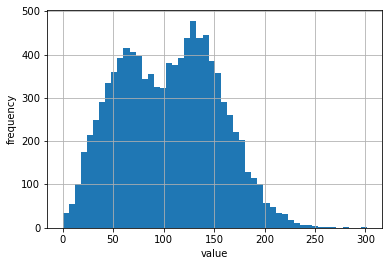

In [77]:
S0 = 100.
r = 0.05
sigma = 0.2
lamb = 0.75
mu = -0.6
delta = 0.25
T = 1.0

M = 50
I = 10000
dt = T / M
rj = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
S = np.zeros((M + 1, I))
S[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
    + sigma * np.sqrt(dt) * sn1[t])
    + (np.exp(mu + delta * sn2[t]) - 1)
    * poi[t])
    S[t] = np.maximum(S[t], 0)

plt.hist(S[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

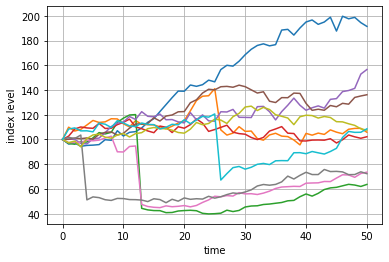

In [78]:
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

We have assumed a highly negative mean for the jump whish shows in the paths we generated above as well as the double-peak distribution of the process. 

This concludes our tutorial and we proceed to apply the techniques we learned here evaluate contingent claims in financial engineering. 